# Gaussian Process Distribution of Relaxation Times. 
## In this tutorial we will reproduce Figure 9 of the article https://doi.org/10.1016/j.electacta.2019.135316Reproduce

This tutorial shows how the GP-DRT model can manage overlapping timescales, where the impedance was generated using two ZARC elements in series. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
%matplotlib inline

## 1) Define parameters for the synthetic impedance based on two ZARCs in series. 

The impedance has the format of 

$$
Z^{\rm exact}(f) = 2R_\infty + \displaystyle \frac{1}{\displaystyle \frac{1}{R_{\rm ct}}+C_1 \left(i 2\pi f\right)^{\phi}} + \displaystyle \frac{1}{\displaystyle\frac{1}{R_{\rm ct}}+C_2 \left(i 2\pi f\right)^{\phi}}
$$ 
where $\displaystyle C_1 = \frac{\tau_1^\phi}{R_{\rm ct}}$ and $\displaystyle C_2 = \frac{\tau_2^\phi}{R_{\rm ct}}$

In this tutorial, $\tau_1=0.1$ and $\tau_2=10$

The analytical DRT is calculated as 

$$
\gamma(\log \tau) = \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \sin\left((1-\phi)\pi\right) \displaystyle \left(\frac{1 }{\displaystyle \cosh(\phi \log(\tau/\tau_1))-\cos(\pi(1-\phi))} +  \displaystyle \frac{1}{\displaystyle \cosh(\phi \log(\tau/\tau_2))-\cos(\pi(1-\phi))}\right)
$$

In [2]:
# define the frequency range
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for two ZARCs in series, the impedance, and the analytical DRT are calculated as the above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_1 = 0.1
tau_2 = 10

C_1 = tau_1**phi/R_ct
C_2 = tau_2**phi/R_ct

Z_exact = 2*R_inf + 1./(1./R_ct+C_1*(1j*2.*pi*freq_vec)**phi) + 1./(1./R_ct+C_2*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)*(1/(np.cosh(phi*np.log(tau/tau_1))-cos((1.-phi)*pi)) +\
                                             1/(np.cosh(phi*np.log(tau/tau_2))-cos((1.-phi)*pi)))

# used for plotting only
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)*(1/(np.cosh(phi*np.log(tau_plot/tau_1))-cos((1.-phi)*pi)) +\
                                                  1/(np.cosh(phi*np.log(tau_plot/tau_2))-cos((1.-phi)*pi)))
# adding random noise to the synthetic data
rng = np.random.seed(214975)
sigma_n_exp = 0.1
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 2) show the synthetic impedance in the Nyquist plot. Note: this is similar to Figure 9 (a)

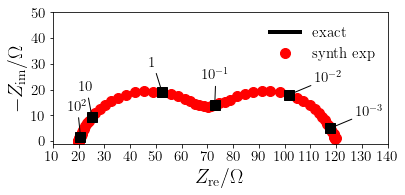

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Nyquist plot of the impedance
fig, ax = plt.subplots()
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synth exp")
plt.plot(np.real(Z_exp[10:70:10]), -np.imag(Z_exp[10:70:10]), 's', markersize=10, color="black")

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 150, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

# label points with frequency
plt.annotate(r'$10^{-3}$', xy=(np.real(Z_exp[10]), -np.imag(Z_exp[10])), 
             xytext=(np.real(Z_exp[10])+10, 5-np.imag(Z_exp[10])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])+10, 5-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-5, 10-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40])-5, 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-5, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^2$', xy=(np.real(Z_exp[60]), -np.imag(Z_exp[60])), 
             xytext=(np.real(Z_exp[60])-5, 10-np.imag(Z_exp[60])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.show()

## 3) Compute the optimal hyperparameters

In [4]:
# initialize the parameters for the minimization of the NMLL, see (31) in the manuscript
sigma_n = sigma_n_exp
sigma_f = 5.
ell = 1.

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}'.format(theta[0], theta[1], theta[2]))

print('sigma_n,   sigma_f,   ell')
# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_f, ell using the Newton-CG method as implemented in scipy
res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', \
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_f, ell = res.x

sigma_n,   sigma_f,   ell
0.0811204  5.0008041  0.9965226
0.0867785  5.0011230  0.9948113
0.0859594  5.0061593  0.9701405
0.0844965  5.0183275  0.9169196
0.0824855  5.0565844  0.7970074
0.0833165  5.0568936  0.7969525
0.0831366  5.2802597  0.7983940
0.0828135  5.7792060  0.8033087
0.0823987  6.8380146  0.8215793
0.0824158  7.5411797  0.8457629
0.0824354  7.7840680  0.8554877
0.0824365  7.8073390  0.8564169
0.0824369  7.8073402  0.8564052
Optimization terminated successfully.
         Current function value: -86.240579
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 76
         Hessian evaluations: 0


## 4) Core of the GP-DRT

### 4a) Compute matrices

In [5]:
# calculate the matrices shown in eq (18)
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

### 4b) Factorize the matrices and solve the linear equations

In [6]:
# the matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$ whose inverse is needed
K_im_full = L2_im_K + Sigma

# Cholesky factorization
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma of eq (21a)
gamma_fct_est = np.dot(L_im_K, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)

# estimate the sigma of gamma for eq (21b)
cov_gamma_fct_est = K - np.dot(L_im_K, np.dot(inv_K_im_full, L_im_K.T))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

### 4c) Plot the obtained DRT against the analytical DRT

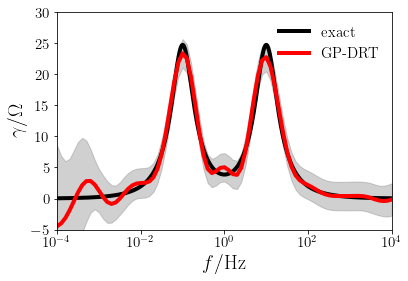

In [7]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec, gamma_fct_est, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec, gamma_fct_est-3*sigma_gamma_fct_est, gamma_fct_est+3*sigma_gamma_fct_est, color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,30])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

### 4d) Predict the $\gamma$ and the imaginary part of the GP-DRT impedance

In [8]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for the plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (23), xi_star corresponds to a new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star_up = GP_DRT.matrix_L_im_K(xi_star, xi_vec, sigma_f, ell)
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_vec, xi_star, sigma_f, ell)
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation using eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute gamma_star mean and standard deviation using eq (29)
    gamma_vec_star[index] = np.dot(L_im_k_star_up, np.dot(inv_K_im_full, Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star_up, np.dot(inv_K_im_full, L_im_k_star_up.T))

### 4e) Plot the imaginary part of the GP-DRT impedance together with the synthetic experiment

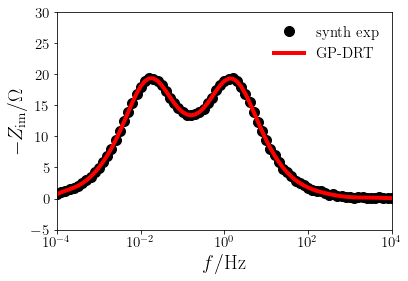

In [9]:
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,30])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()